# GPAR

## 1) Install GPAR

In [ ]:
import sys
!{sys.executable} -m pip install gpar

## 2) Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gpar

In [2]:
from scipy.special import iv
from scipy.optimize import fsolve

from gpar.regression import GPARRegressor
from scipy.stats import vonmises
from scipy import stats
from scipy.stats import entropy
from scipy import interpolate

## 3) Define Functions

#### Functions below compute fits and pdf of Vonmises

In [3]:
def vonmises_density(x,mu,kappa):
    """
    Calculate the von Mises density for a series x (a 1D numpy.array).
    Input : 
        x : a 1D numpy.array of size L
        mu : a 1D numpy.array of size n, the mean of the von Mises distributions
        kappa : a 1D numpy.array of size n, the dispersion of the von Mises distributions
    Output : 
        a (L x n) numpy array, L is the length of the series, and n is the size of the array containing the parameters. Each row of the output corresponds to a density
    """
    res = []
    for i in x:
        f = np.exp(kappa*np.cos(i-mu))
        n = 2*np.pi*iv(0,kappa)
        res.append(f/n)
    return(np.array(res))

def vonmises_pdfit(series):
    """
    Calculate the estimator of the mean and deviation of a sample, for a von Mises distribution
    Input : 
        series : a 1D numpy.array
    Output : 
        the estimators of the parameters mu and kappa of a von Mises distribution, in an list [mu, kappa]
    """
    s0 = np.mean(np.sin(series))
    c0 = np.mean(np.cos(series))
    mu = np.arctan2(s0,c0)
    var = 1-np.sqrt(s0**2+c0**2)
    k = lambda kappa: 1-iv(1,kappa)/iv(0,kappa)-var
    kappa = fsolve(k, 0.0)[0]
    return([mu,kappa])

#### Function below computes KL divergence

In [4]:
# Here is the function to define KL divergence
# Note: the samplepdf and observationpdf is the probability density function, not the sample count.
def kldiver(samplepdf, observationpdf):
    print("\nIndividual Entropy\n")
    print(entropy(samplepdf))
    print(entropy(observationpdf))

    print("\nPairwise Kullback Leibler divergence\n")
    firstkl = entropy(samplepdf, qk=observationpdf)
    secondkl = entropy(observationpdf, qk=samplepdf)
    print(firstkl)
    print(secondkl)
    return (firstkl,secondkl)

#### Function below computes inverse sampling

In [5]:
def invcdf(vals, pdf, num_sam):
    # Normalize
    normalize = pdf/np.sum(pdf)
    p = np.cumsum(normalize)
    # define inverse function
    inv_cdf = interpolate.interp1d(p,vals,bounds_error=False, fill_value = (-math.pi, math.pi))
    # get number of data
    r = np.random.rand(num_sam)
    # get sample
    sample = inv_cdf(r)
    return sample

#### Function below compute MSE and MAE

In [6]:
# Here is the function to define the MSE and MAE
def countdiff(bins, sample, observation):
    if len(observation) != len(sample):
        print("Please generate the same length data")
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    print('The MSE is ' + str(mse))
    print('The MAE is ' + str(mae))
    return mse, mae 

#### Function below compute MSE

In [7]:
# Here is the function to define the MSE
def countdiffmse(bins, sample, observation):
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    return mse

#### Function below compute MAE

In [8]:
# Here is the function to define the MAE
def countdiffmae(bins, sample, observation):
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    return mae

#### Function Below compute average KL divergence of both way

In [9]:
# Here is the function to define KL divergence
# Note: the samplepdf and observationpdf is the probability density function, not the sample count.

def kldiver2(samplepdf, observationpdf):
    #print("\nIndividual Entropy\n")
    #print(entropy(samplepdf))
    #print(entropy(observationpdf))

    #print("\nPairwise Kullback Leibler divergence\n")
    firstkl = entropy(samplepdf, qk=observationpdf)
    secondkl = entropy(observationpdf, qk=samplepdf)
    #print(firstkl)
    #print(secondkl)
    #return (firstkl,secondkl)
    return (firstkl+secondkl)/2

# Data

#### Load Data - Drop any unnecessary Columns you may have

In [11]:
df = pd.read_csv("sample.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()

,day,weekday,wakeup,firstMeal,lastMeal,sleep
0,1,Monday,5.94,8.05,17.83,21.08
1,2,Tuesday,6.02,7.99,17.87,21.16
2,3,Wednesday,6.19,8.22,18.05,21.14
3,4,Thursday,5.99,8.08,18.11,20.95
4,5,Friday,5.83,8.06,17.78,20.75


#### Convert Time String to make sure it will be in format (HH:MM:SS)

In [ ]:
#start = []
#end = []
#for i in range(len(df['start_time'])):
#    if len(df['start_time'][i]) < 8:
#        start.append('0' + df['start_time'][i])
#    else:
#        start.append(df['start_time'][i])
#    
#    if len(df['end_time'][i]) < 8:
#        end.append('0' + df['end_time'][i])
#    else:
#        end.append(df['end_time'][i])
#df['start_time'] = start
#df['end_time'] = end

#### Convert time string in integer value 0 - 24

In [ ]:
#convert_start = []
#convert_end = []
#for i in range(0,len(df["end_time"])):
#    convert_start.append(int(df["start_time"][i][0:2]) + int(df["start_time"][i][3:5])/60 + int(df["start_time"][i][6:])/3600)
#    convert_end.append(int(df["end_time"][i][0:2]) + int(df["end_time"][i][3:5])/60 + int(df["end_time"][i][6:])/3600)
#df["starthour"] = convert_start
#df["endhour"] = convert_end

#### Convert time into $-\pi$ to $\pi$

In [13]:
wake = df["wakeup"] * math.pi /12 - math.pi
sleep = df["sleep"] * math.pi /12 - math.pi

In [14]:
meal1 = df["firstMeal"] * math.pi /12 - math.pi
meal2 = df["lastMeal"] * math.pi /12 - math.pi

#### Fit each of different type

In [15]:
wake_val = vonmises_pdfit(wake)
print(wake_val)
sleep_val = vonmises_pdfit(sleep)
print(sleep_val)

[-1.499355970023588, 63.955037028964966]
[2.4314895384784863, 66.32534957159996]


In [16]:
food1 = vonmises_pdfit(meal1)
print(food1)
food2 = vonmises_pdfit(meal2)
print(food2)

[-0.9732696449573787, 68.98089767207576]
[1.6405517074358231, 69.1670164319464]


### Run GPAR

#### There are many different ways to create different functions. The example below shows one of many ways the code could run.

Training conditionals (total: 4): 1 2 3 4
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
Training conditionals (total: 4): 1 2 3 4
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 6

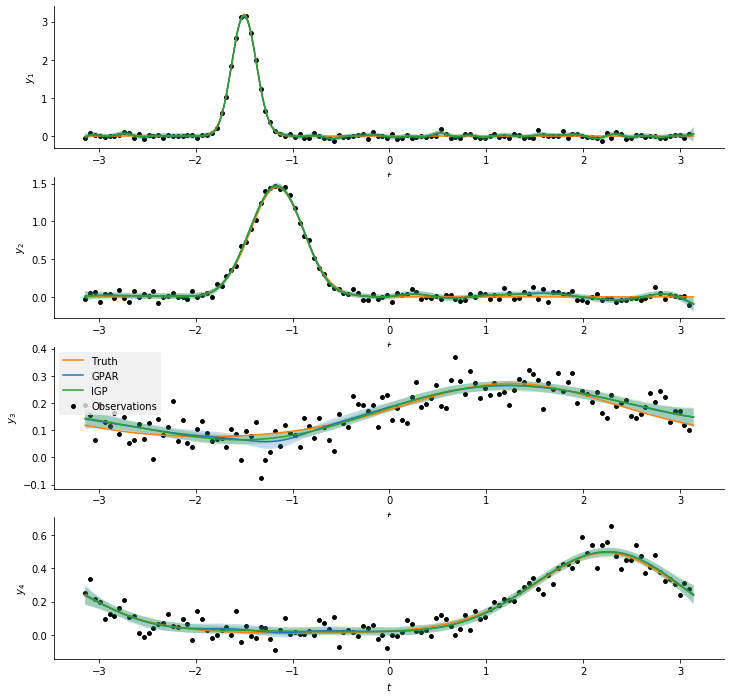

In [37]:
# Create toy data set.
n = 1000
x = np.linspace(-math.pi, math.pi, n)
noise = 0.05

# Draw functions depending on each other in complicated ways.
# Wake
f1 = vonmises_density(x,wake_val[0],wake_val[1])
a1 = vonmises.rvs(wake_val[1],wake_val[0], size = 100)
# Food
food_val_a1 = vonmises_pdfit(list(meal1) +list(a1))
f2 = vonmises_density(x,food_val_a1[0],food_val_a1[1])
a2 = vonmises.rvs(food_val_a1[1],food_val_a1[0], size = 100)

food_val_a2 = vonmises_pdfit(list(meal2) +list(a2))
f3 = vonmises_density(x,food_val_a2[0],food_val_a2[1])
a3 = vonmises.rvs(food_val_a2[1],food_val_a2[0], size = 100)

# Sleep 
sleep_val_b = vonmises_pdfit(list(sleep) + list(a3))
f4 = vonmises_density(x,sleep_val_b[0],sleep_val_b[1])

f = np.stack((f1, f2, f3, f4), axis=0).T

# Add noise and subsample.
y = f + noise * np.random.randn(n, 4)
x_obs, y_obs = x[::8], y[::8]

# Fit and predict GPAR.
model = GPARRegressor(scale=0.1,
                      linear=False, #linear_scale=10.,
                      nonlinear=True, nonlinear_scale=1,
                      noise=0.05,
                      impute=True, replace=True, normalise_y=False)
model.fit(x_obs, y_obs)
means, lowers, uppers = \
    model.predict(x, num_samples=200, credible_bounds=True, latent=True)

# Fit and predict independent GPs: set markov=0.
igp = GPARRegressor(scale=0.1,
                    linear=False, #linear_scale=10.,
                    nonlinear=True, nonlinear_scale=1,
                    noise=0.05, markov=0, normalise_y=False)
igp.fit(x_obs, y_obs)
igp_means, igp_lowers, igp_uppers = \
    igp.predict(x, num_samples=200, credible_bounds=True, latent=True)

# Plot the result.
plt.figure(figsize=(12, 12))

for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.scatter(x_obs, y_obs[:, i], label='Observations', c='black', s=15)
    plt.plot(x, f[:, i], label='Truth', c='tab:orange')
    plt.plot(x, means[:, i], label='GPAR', c='tab:blue')
    plt.fill_between(x, lowers[:, i], uppers[:, i],
                     facecolor='tab:blue', alpha=.25)
    plt.plot(x, igp_means[:, i], label='IGP', c='tab:green')
    plt.fill_between(x, igp_lowers[:, i], igp_uppers[:, i],
                     facecolor='tab:green', alpha=.25)
    plt.xlabel('$t$')
    plt.ylabel('$y_{}$'.format(i + 1))
    if i == 2:
        leg = plt.legend(facecolor='#eeeeee')
        leg.get_frame().set_linewidth(0)

plt.show()

#### Make one gigantic function

In [44]:
comb = []
for i in range(0, len(igp_means)):
    comb.append(igp_means[:,0][i]/4 + igp_means[:,1][i]/4 + igp_means[:,2][i]/4 + igp_means[:,3][i]/4)
    
listall = list(wake) + list(sleep) + list(meal1) + list(meal2)

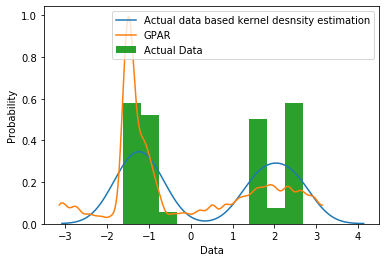

In [45]:
sns.kdeplot(listall,label='Actual data based kernel desnsity estimation')
plt.plot(x, comb, label = 'GPAR')
plt.hist(listall,density=True,label='Actual Data')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.legend()

#### Compute KL

In [40]:
# generate the probability density function based on actual data
actual_density = stats.kde.gaussian_kde(listall)
actual_density = actual_density(x)
kldiver(actual_density, comb)


Individual Entropy

6.902034078131946
6.4900333061155075

Pairwise Kullback Leibler divergence

0.3488647300661589
0.3919691803560431


(0.3488647300661589, 0.3919691803560431)

#### Compute MAE and MSE

In [41]:
papermse = []
papermae = []
for i in range(1000):
    samples = invcdf(x,comb, len(listall))
    papermse.append(countdiffmse(48,samples, listall))
    papermae.append(countdiffmae(48,samples, listall))

In [42]:
meanmse = np.mean(papermse)
meanmae = np.mean(papermae)
lowersmse = np.percentile(papermse, 2.5)
uppersmse = np.percentile(papermse, 100 - 2.5)
lowersmae = np.percentile(papermae, 2.5)
uppersmae = np.percentile(papermae, 100 - 2.5)

print("MSE mean is " + str(meanmse))
print("MSE lower is " + str(lowersmse))
print("MSE upper is " + str(uppersmse))

print("MAE mean is " + str(meanmae))
print("MAE lower is " + str(lowersmae))
print("MAE upper is " + str(uppersmae))

MSE mean is 202.8282708333333
MSE lower is 176.70520833333333
MSE upper is 228.51666666666665
MAE mean is 8.295020833333332
MAE lower is 7.666666666666667
MAE upper is 8.958854166666667
